In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sandp500/merge.sh
/kaggle/input/sandp500/getSandP.py
/kaggle/input/sandp500/all_stocks_5yr.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._.DS_Store
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._ABC_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._AAPL_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._A_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/__MACOSX/individual_stocks_5yr/._MAS_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/CL_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/FDX_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/AMAT_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/GLW_data.csv
/kaggle/input/sandp500/individual_stocks_5yr/individual_stocks_5yr/ANSS_data.csv
/kaggle/input/sandp500/individual_stock

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


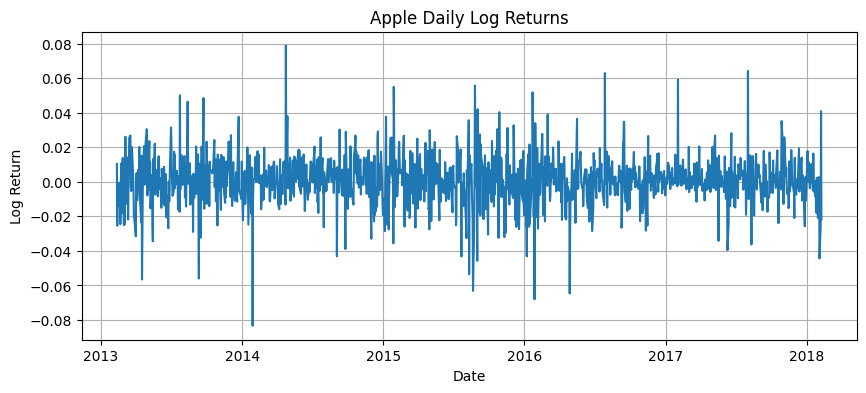

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/sandp500/all_stocks_5yr.csv')

apple = df[df['Name']=='AAPL'].copy()

apple['date'] = pd.to_datetime(apple['date'])
apple.sort_values('date', inplace=True)

apple['log_return'] = np.log(apple['close']/apple['close'].shift(1))#log returns
apple.dropna(inplace=True)

plt.figure(figsize=(10,4))
plt.plot(apple['date'], apple['log_return'])
plt.title("Apple Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid()
plt.show()


In [3]:
returns = apple[['date','log_return']].set_index('date')
returns = returns * 100 


In [4]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 22.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from arch import arch_model

am = arch_model(returns, vol='GARCH', p=1, q=1, dist='t')#t distributed
res = am.fit(disp='off')
print(res.summary())

forecast = res.forecast(horizon=1)
print(forecast.variance.iloc[-1])


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2150.38
Distribution:      Standardized Student's t   AIC:                           4310.76
Method:                  Maximum Likelihood   BIC:                           4336.45
                                              No. Observations:                 1258
Date:                      Mon, Aug 04 2025   Df Residuals:                     1257
Time:                              19:24:27   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [6]:
#alpha+beta=1 so didnt optimise further

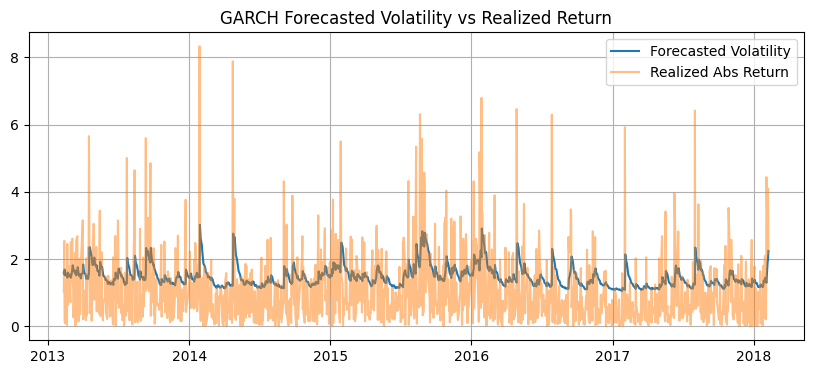

In [7]:
rolling_forecast = res.conditional_volatility
plt.figure(figsize=(10,4))
plt.plot(rolling_forecast, label='Forecasted Volatility')
plt.plot(returns.index, returns['log_return'].abs(), alpha=0.5, label='Realized Abs Return')
plt.legend()
plt.title('GARCH Forecasted Volatility vs Realized Return')
plt.grid()
plt.show()


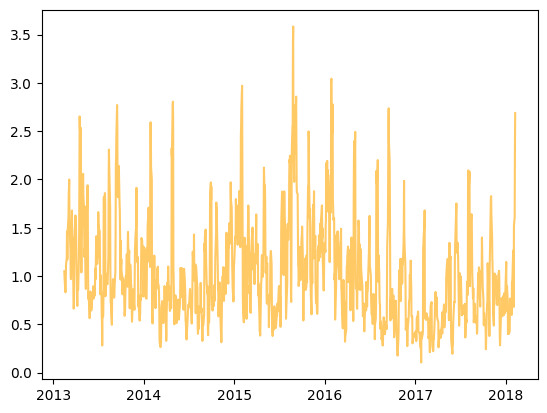

In [8]:
realized_smooth = returns['log_return'].abs().rolling(window=5).mean()
plt.plot(realized_smooth, label='Smoothed Abs Return', color='orange', alpha=0.6)


In [9]:
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import numpy as np


In [10]:
std_resid = res.resid/res.conditional_volatility
std_resid.dropna(inplace=True)


In [11]:
threshold=np.percentile(std_resid,95)
exceedances=std_resid[std_resid>threshold]-threshold


In [12]:
params=genpareto.fit(exceedances)
shape,loc,scale= params
print(f"Shape : {shape:.4f}, Scale : {scale:.4f}")


Shape : 0.3137, Scale : 0.4999


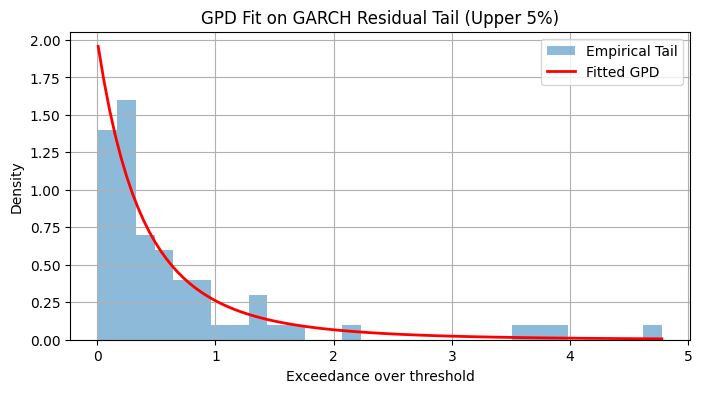

In [13]:
x = np.linspace(min(exceedances), max(exceedances), 100)
pdf = genpareto.pdf(x, shape, loc=0, scale=scale)#pareto

plt.figure(figsize=(8,4))
plt.hist(exceedances, bins=30, density=True, alpha=0.5, label='Empirical Tail')
plt.plot(x, pdf, 'r-', lw=2, label='Fitted GPD')
plt.title("GPD Fit on GARCH Residual Tail (Upper 5%)")
plt.xlabel("Exceedance over threshold")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()


In [14]:
x_val = 3-threshold
tail_prob = genpareto.sf(x_val, shape, loc=0, scale=scale)
print(f"Probability of >3 std deviation shock: {tail_prob:.4%}")


Probability of >3 std deviation shock: 11.2593%


In [16]:
nu = res.params['nu']
t_quant_95 =t.ppf(0.05,df=nu)
t_quant_99 =t.ppf(0.01,df=nu)

VaR_95 =res.conditional_volatility*t_quant_95
VaR_99 =res.conditional_volatility*t_quant_99

returns_series = res.resid  # raw residuals
violations_95 =(returns_series < VaR_95).astype(int)
violations_99 =(returns_series < VaR_99).astype(int)

violation_rate_95 = violations_95.sum() / len(violations_95)
violation_rate_99 = violations_99.sum() / len(violations_99)

print(f"95% VaR Violation Rate: {violation_rate_95:.2%}")
print(f"99% VaR Violation Rate: {violation_rate_99:.2%}")

95% VaR Violation Rate: 2.07%
99% VaR Violation Rate: 0.24%


In [17]:
def kupiec_test(actual, alpha):
    from math import log
    T = len(actual)
    x = sum(actual)
    p_hat = x / T
    LR = -2 * (log((1 - alpha)**(T - x) * alpha**x) -
               log((1 - p_hat)**(T - x) * p_hat**x))#kupiec's test
    return LR

print("Kupiec LR 95%:", kupiec_test(violations_95, 0.05))
print("Kupiec LR 99%:", kupiec_test(violations_99, 0.01))


Kupiec LR 95%: 28.988398472016343
Kupiec LR 99%: 10.632527123464712
